# Model for Target
The goal of this Notebook is to build a model for TARGET with more than the 0.17 precision score (Dummy model was build in Notebook 4, with > 80 features).

Main steps of this notebook:
* Null values for missing previous application are made to be NULL, as them being missing represents the physical world. Rest of missing values are imputed to mean.
/* Data is split to 3 parts (70/15/15).
* Default various model behavior check with LazyPredict.
* Hyperparameter tuning for maximizing ROC AUC, done with Optuna.
* Optimal Threshold is found, for maximum Precision.
* Model is checked against unseen data.
* Value importance is explained via SHAP values.

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier

import shap
import optuna
import joblib

# Custom imports
from help_tool import help_tool, help_model

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)

pd.set_option('future.no_silent_downcasting', True)
pd.plotting.register_matplotlib_converters()

optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme(style='whitegrid')
sns.set_palette('husl')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
selected_data = help_tool.csv_download(
    r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')

In [17]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] ==
                  selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

# Bucketing
selected_data['YEARS_BIRTH'] = help_tool.bucket_age_feature(
    selected_data, 'YEARS_BIRTH')
for feature in ['YEARS_EMPLOYED', 'AMT_CREDIT']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(
        selected_data, feature, 5)


selected_data = selected_data[selected_data['CODE_GENDER_F'].notna(
)].drop_duplicates()

In [18]:
selected_data.rename(columns={
    'MAX(df.DURATION_DUE_VERSION)': 'Max_DURATION_DUE_VERSION',
    'MAX(df.DURATION_DECISION_DRAWING)': 'Max_DURATION_DECISION_DRAWING',
    'MIN(df.RATIO_GOODS_PRICE_CREDIT)': 'Min_RATIO_GOODS_PRICE_CREDIT',
    'MIN(df.DURATION_DECISION_DRAWING)': 'Min_DURATION_DECISION_DRAWING'
}, inplace=True)

# Missing values
AVG Risk Score is one of the beggest impactor for TARGT, same as EXT_SOURCE family. 

Notebook 4 had a feature importance check, in which top most important features were found - ['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3']. These features were attempted to impute via LGBMRegressor and Ridge Regression. However, in previous findings it was seen that these features have no correlation, different distributions, have random places of missing values, and so building a model for imputation didn't succeed. Imputing external data would have 

As it seams like missing values are random, the next best thing is the simple imputation by mean.

In [19]:
for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AVG_Risk_Score']:
    selected_data.loc[selected_data[feature].isna(
    ), feature] = selected_data[feature].mean()

Features like Duration are missing when person had no previous application, these empty values will be left in as NaN has a physical meaning.

In [20]:
selected_data.isna().sum()

EXT_SOURCE_1                         0
NAME_EDUCATION_TYPE                  0
AMT_CREDIT                           0
Max_DURATION_DUE_VERSION         17749
YEARS_EMPLOYED                   55373
EXT_SOURCE_3                         0
YEARS_BIRTH                          0
Max_DURATION_DECISION_DRAWING    17749
EXT_SOURCE_2                         0
Min_RATIO_GOODS_PRICE_CREDIT     17436
AVG_Risk_Score                       0
Min_DURATION_DECISION_DRAWING    17749
CODE_GENDER_F                        0
TARGET                               0
YEARS_LAST_PHONE_CHANGE              1
dtype: int64

# TARGET
## Dummy models for reference
Dummy model will be found via Lazypredict.

In [142]:
selected_data_sample = selected_data.sample(10000, random_state=42)

X = selected_data_sample.drop('TARGET', axis=1)

y = selected_data_sample['TARGET']


# Split data into train, validation, and test sets

X_train, X_temp, y_train, y_temp, = train_test_split(

    X, y, test_size=0.3, random_state=42, stratify=y)


X_validation, X_test, y_validation, y_test, = train_test_split(

    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
classif_models, predictions = clf.fit(
    X_train, X_validation, y_train, y_validation)

 97%|█████████▋| 28/29 [00:18<00:00,  1.88it/s]

[LightGBM] [Info] Number of positive: 538, number of negative: 6462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076857 -> initscore=-2.485836
[LightGBM] [Info] Start training from score -2.485836


100%|██████████| 29/29 [00:19<00:00,  1.53it/s]


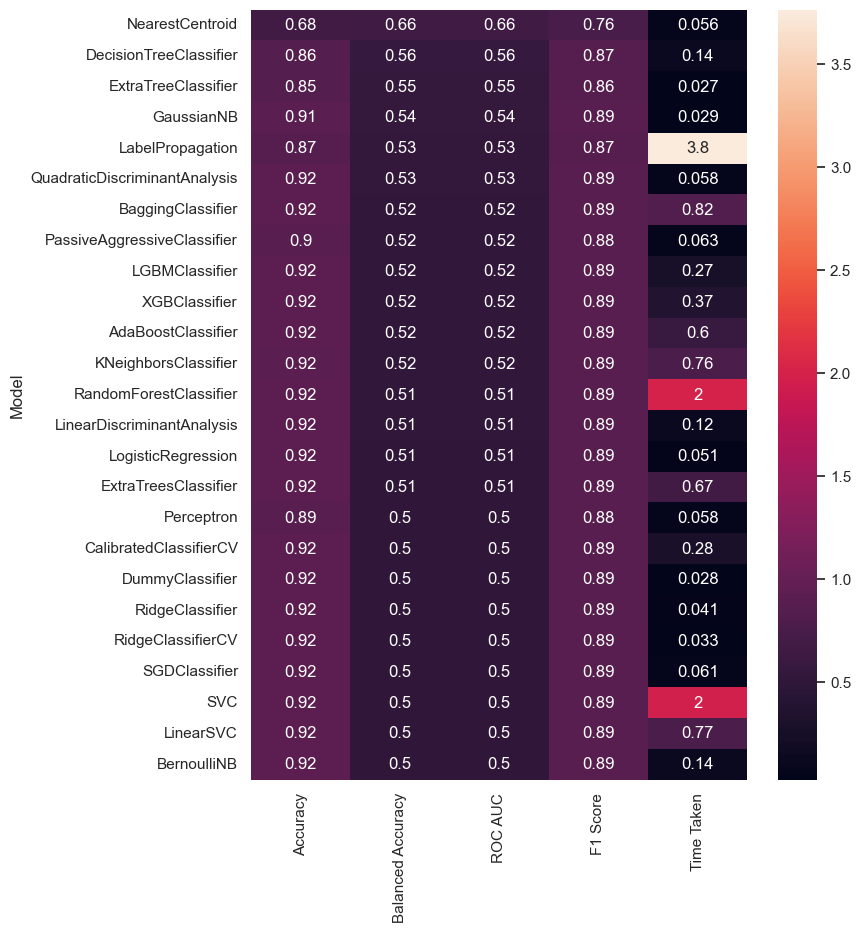

In [143]:
plt.figure(figsize=(8, 10))

sns.heatmap(classif_models[(classif_models['Time Taken'] < 5)], annot=True)
plt.show()

LGBMClassifier was chosen, as it's fast, has great performance, handles large datasets, can handle less data cleaning. The goal is to create a model with ROC AUC 0.51 or better.

Another great solution is the DecisionTree - ROC AUC of 0.54.

In [21]:
selected_data_sample = selected_data.sample(100000, random_state=42)

X = selected_data_sample.drop('TARGET', axis=1)
y = selected_data_sample['TARGET']


# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp, = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_validation, X_test, y_validation, y_test, = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(
    f"X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (70000, 14), y_train shape: (70000,)
X_validation shape: (15000, 14), y_validation shape: (15000,)
X_test shape: (15000, 14), y_test shape: (15000,)


# LightGBM
## Hyperparameter Tuning
Hyperparameter search is done using Pipeline and Optuna. Best hyperparameters were found by  reducing the available size of max_bin and num_leaves, adding path_smooth. Hyperparameter changes change strategy was taken from 
 [lightgbm.readthedocs.io](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).

Hyperparameters are tuned for maximazing ROC AUC.

In [53]:
def objective(trial, X_train, y_train):
    params = {
        'max_bin': trial.suggest_int('max_bin', 2, 30),
        'num_leaves': trial.suggest_int('num_leaves', 2, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'path_smooth': trial.suggest_float('path_smooth', 0, 10),
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced'
    }

    model = LGBMClassifier(**params, random_state=42, verbose=-1)

    scorer = make_scorer(roc_auc_score)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    mean_roc = cv_scores.mean()
    return (mean_roc)


def objective_with_data(trial):
    return objective(trial, X_train, y_train)


study = optuna.create_study(direction='maximize')
study.optimize(objective_with_data, n_trials=50)

best_trial = study.best_trial


print('Best trial:')
print(f'  Value (Mean ROC): {best_trial.value:.4f}')

print('  Params:')

for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value (Mean ROC): 0.6838
  Params:
    max_bin: 17
    num_leaves: 9
    min_data_in_leaf: 12
    min_sum_hessian_in_leaf: 0.45370493280210084
    bagging_fraction: 0.6500383749938645
    bagging_freq: 1
    feature_fraction: 0.7522460210866514
    lambda_l1: 0.5153748551195523
    lambda_l2: 0.28563079193987717
    min_gain_to_split: 0.18994028500679183
    max_depth: 4
    extra_trees: False
    path_smooth: 8.28818030630295


Since parameter tuning takes time, one of the best runs is saved for future replicability.

In [261]:
lightgbm_params = {
    'max_bin': 17,
    'num_leaves': 9,
    'min_data_in_leaf': 12,
    'min_sum_hessian_in_leaf': 0.45370493280210084,
    'bagging_fraction': 0.6500383749938645,
    'bagging_freq': 1,
    'feature_fraction': 0.7522460210866514,
    'lambda_l1': 0.5153748551195523,
    'lambda_l2': 0.28563079193987717,
    'min_gain_to_split': 0.18994028500679183,
    'max_depth': 4,
    'extra_trees': False,
    'path_smooth': 8.28818030630295
}

After model fitting with default threshold, there's not much difference between Train and Validation data scores.

In [357]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(**lightgbm_params, verbose=-1))
])

lightgbm_pipeline = pipeline.fit(X_train, y_train)


help_model.multi_evaluation(
    lightgbm_pipeline, X_train, y_train, X_validation, y_validation)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC,Type
0,LGBMClassifier,False,0.92,0.63,0.01,0.02,0.77,Train
1,LGBMClassifier,False,0.92,0.58,0.01,0.02,0.75,Validate


Setting a copy of model lightgbm_pipeline. This is done, because later 'Cross Validation' code would re-fit the model. To ensure replication, separate steps will have their own model copies.

In [264]:
lgbm = copy.deepcopy(lightgbm_pipeline)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC,Type
0,LGBMClassifier,False,0.92,0.63,0.01,0.02,0.77,Train
1,LGBMClassifier,False,0.92,0.58,0.01,0.02,0.75,Validate


## Threshold Tuning
Optimal Thresholds is tuned on maxumum Precission. This is done as the data is imbalanced and the minority class is the main focus of this model.

Optimal threshold (0.12) for LightGBM is smaller than the default (0.5). Which translates to model becoming less strict on minority class possibility.

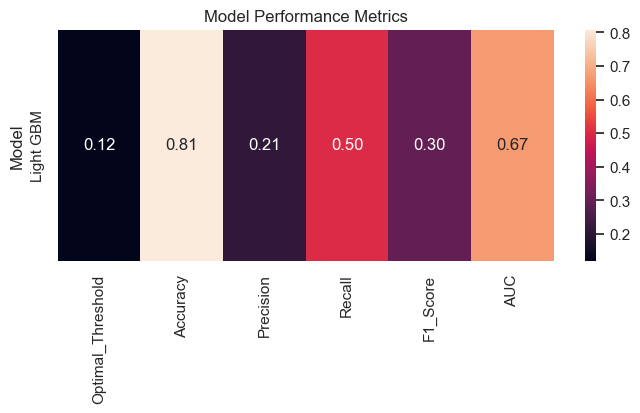

In [265]:
# Setting a copy of model
threshold_lightgbm_pipeline = copy.deepcopy(lightgbm_pipeline)

lightgbm_threshold = help_model.find_threshold(

    threshold_lightgbm_pipeline, X_validation, y_validation, 'LightGBM')

## Testing on 3rd partition
Before moving on, let's evaluate if model performs with Test set and tuned threshold. Test set doesn't show any drastic drops in scores, LightGBM is ready for other steps.

The default score for Precision was 0.17. LightGBM has an increase of 0.21.

In [266]:
help_model.model_evaluations_threshold(
    lgbm, lightgbm_threshold, X_test, y_test)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC
0,LGBMClassifier,0.12,0.80,0.21,0.50,0.29,0.67


## Conclusion
LightGBM was tuned with hyperparameters and with optimal threshold has Precision of 0.21 (an increase from default model).

# Decission Tree
## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and Optuna. Overfitting was combated by decreasing max_depth and min_samples_split Hyperparameter.

In [178]:
def objective(trial, X_train, y_train):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 1.0)
    }

    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(**params, random_state=42))
    ])

    scorer = make_scorer(roc_auc_score)

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring=scorer)

    mean_roc = cv_scores.mean()
    return (mean_roc)


def objective_with_data(trial):
    return objective(trial, X_train, y_train)


# Optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_with_data, n_trials=50)

best_trial = study.best_trial


print('Best trial:')
print(f'  Value (Mean ROC): {best_trial.value:.4f}')

print('  Params:')

for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value (Mean ROC): 0.6526
  Params:
    max_depth: 14
    min_samples_split: 28
    min_samples_leaf: 2
    max_features: None
    class_weight: balanced
    max_leaf_nodes: 41
    ccp_alpha: 0.00010306625312971529


Again, best parameters are saved for replicability.

In [270]:
dtree_params = {
    'max_depth': 14,
    'min_samples_split': 28,
    'min_samples_leaf': 2,
    'max_features': None,
    'class_weight': 'balanced',
    'max_leaf_nodes': 41,
    'ccp_alpha': 0.00010306625312971529
}

After Decission Tres fitting, scores seam simillar.

In [271]:
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(**dtree_params))
])


dtree_pipeline = pipeline.fit(X_train, y_train)

# Pipeline copy
dtree = copy.deepcopy(dtree_pipeline)


help_model.multi_evaluation(dtree_pipeline, X_train,
                            y_train, X_validation, y_validation)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC,Type
0,DecisionTreeClassifier,False,0.62,0.14,0.73,0.24,0.73,Train
1,DecisionTreeClassifier,False,0.62,0.14,0.72,0.23,0.71,Validate


## Threshold Tunning
Threshold tuning shows that the best threshold is close to default threshold of 0.5.

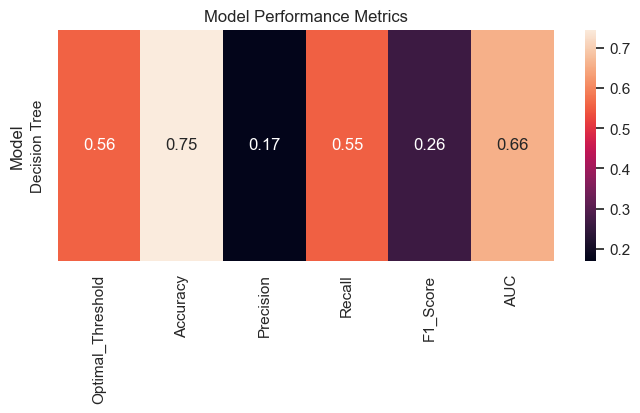

In [273]:
# Pipeline copy
threshold_dtree_pipeline = copy.deepcopy(dtree_pipeline)

dtree_threshold = help_model.find_threshold(

    threshold_dtree_pipeline, X_validation, y_validation, 'Decision Tree')

## Testing on 3rd partition
Lastly, models performance with Test set and tuned threshold is different that LightGBM, but this can be addressed in Cross Validation part.

In [274]:
help_model.model_evaluations_threshold(dtree, dtree_threshold, X_test, y_test)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC
0,DecisionTreeClassifier,0.56,0.74,0.17,0.55,0.26,0.65


## Conclusion
Decision Tree has similar Threshold to Default Threshold. Precision is not different than Default Model.

# Cross Validation
Cross Validation will be performed on both of the models. Making sure the good results are not just a chance.

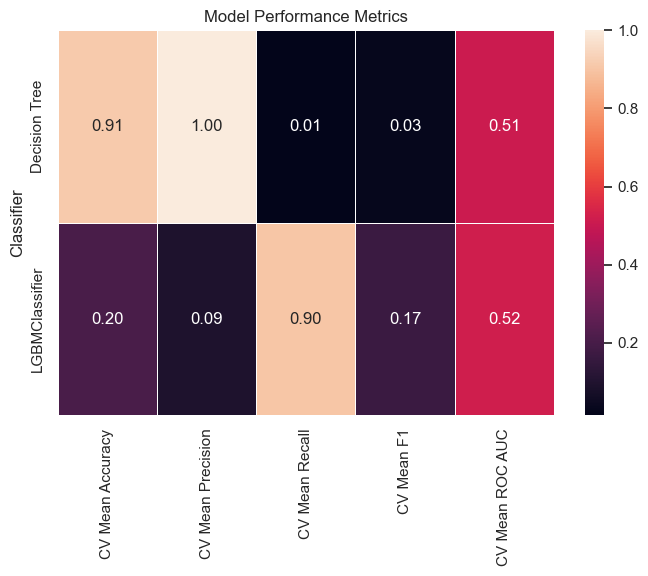

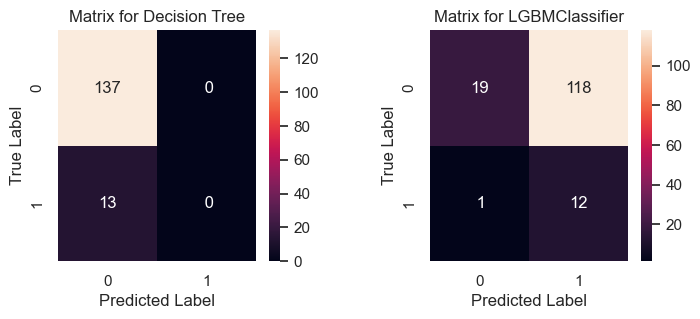

In [276]:
# Pipeline copy
lgbm_cross_pipeline = copy.deepcopy(lightgbm_pipeline)
dtree_cross_pipeline = copy.deepcopy(dtree_pipeline)

classifiers = {
    'Decision Tree': lgbm_cross_pipeline,
    'LGBMClassifier': dtree_cross_pipeline
}


thresholds = {
    'Decision Tree': dtree_threshold,
    'LGBMClassifier': lightgbm_threshold
}


def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = help_model.cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(10, X_validation, y_validation, thresholds, classifiers)

Sadly, Decision Tree took high Precision too hard and is not guessing any minority classes, while LightGBM is guessing the minority class quite well.
# Soft Voting Classifier
Decision Tree and LightGBM have different guessing patterns - Decision Tree guesses only majority class, while LightGBM guesses minority. Because of this difference in behaviour, Soft Voting was chosen.

In [30]:
# Pipeline copy
voting_dtree_pipeline = copy.deepcopy(dtree_pipeline)
voting_lgbm_pipeline = copy.deepcopy(lightgbm_pipeline)


voting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('classifier', VotingClassifier(estimators=[('dtree', voting_dtree_pipeline), ('lgbm', voting_lgbm_pipeline)], 
                                    voting='soft', 
                                    flatten_transform=True, 
                                    weights=[1, 1]))
])

voting_pipeline.fit(X_train, y_train)

voting = copy.deepcopy(voting_pipeline)

help_model.multi_evaluation(voting_pipeline, X_train,
                            y_train, X_validation, y_validation)

,Classifier,Threshold,Accuracy,Precision,Recall,F1,AUC,Type
0,VotingClassifier,False,0.90,0.33,0.19,0.24,0.75,Train
1,VotingClassifier,False,0.90,0.31,0.17,0.22,0.73,Validate


## Threshold Tunning
Voting model also had Trsold tunning, which resulted in a compromise between the 0.12 and 0.56. Meaning, this model should be more nuanced.

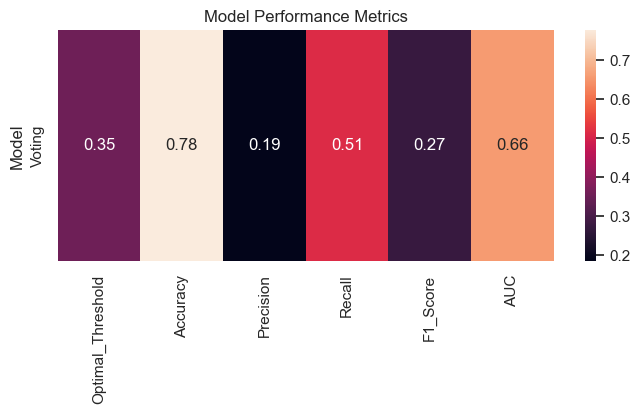

In [31]:
threshold_voting_pipeline = copy.deepcopy(voting_pipeline)
voting_threshold = help_model.find_threshold(

    threshold_voting_pipeline, X_validation, y_validation, 'Voting')

## Cross Validation
Cross Validation shows Soft Voting is much more tunned to the mayority class, but still guesses some minority values.

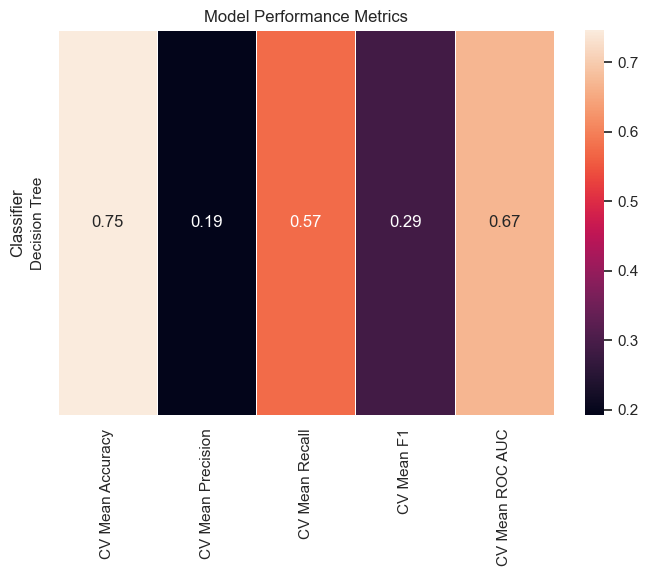

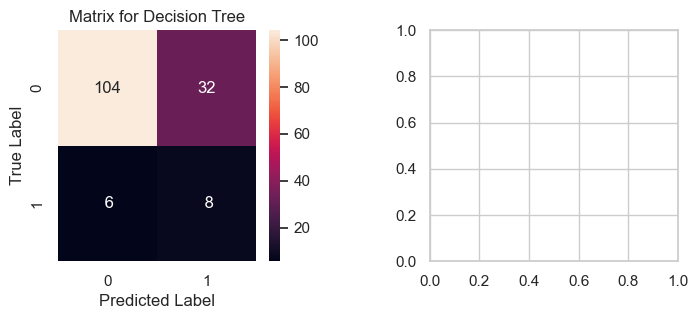

In [37]:
# Pipeline copy
voting_cross_pipeline = copy.deepcopy(threshold_voting_pipeline)

classifiers = {
    'Decision Tree': voting_cross_pipeline,
}


thresholds = {
    'Decision Tree': voting_threshold,
}


def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = help_model.cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(10, X_validation, y_validation, thresholds, classifiers)

# Test data (3rd partition)
Models have been already tested on 3rd data partition set. This part is intended for model comparison. Below picture shows LightGBM having more balance with higher F1 score. Also, the previous section in Cross Validation showed that Decision Tree is not predicting minority class. Voting model has similar Test stats to Decision Tree.

Light GBM is chosen as the best model.

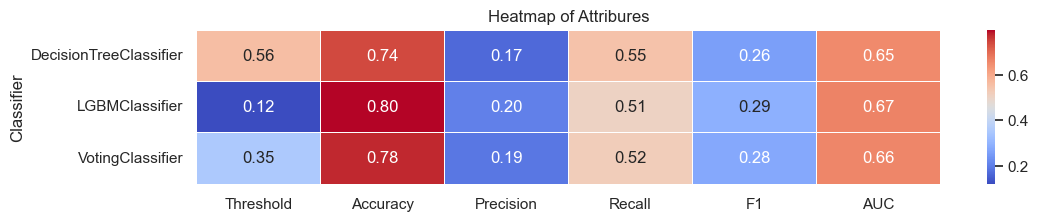

In [36]:
def value_presentation(X_eval, y_eval):

    df_1 = help_model.model_evaluations_threshold(
        dtree, dtree_threshold, X_eval, y_eval)
    df_2 = help_model.model_evaluations_threshold(
        lgbm, lightgbm_threshold, X_eval, y_eval)
    df_3 = help_model.model_evaluations_threshold(
        voting, voting_threshold, X_eval, y_eval)

    joined_df = pd.concat([df_1, df_2, df_3]).set_index('Classifier')

    plt.figure(figsize=(12, 2))
    sns.heatmap(joined_df, annot=True, cmap='coolwarm',
                fmt='.2f', linewidths=.5)
    plt.title('Heatmap of Attribures')

    plt.show()


value_presentation(X_test, y_test)

In [358]:
joblib.dump(lightgbm_pipeline, "model.pkl")

['model.pkl']

# Model explanability
LightGBM was chosen as best model, as it had the best scores out of all of the models.

In [369]:
background_sample = shap.sample(X_validation, 600)

classifier = lightgbm_pipeline.named_steps['classifier']


explainer = shap.Explainer(classifier)

shap_values = explainer.shap_values(X_validation)

External Sources and Duration of various events had the biggest impact on model. For example, hight EXT_SOURCE_2 and EXT_SOURCE_3 had negatively effected the output. While YEARS_LAST_PHONE_CHANGE and YEARS_BIRTH had no impact.

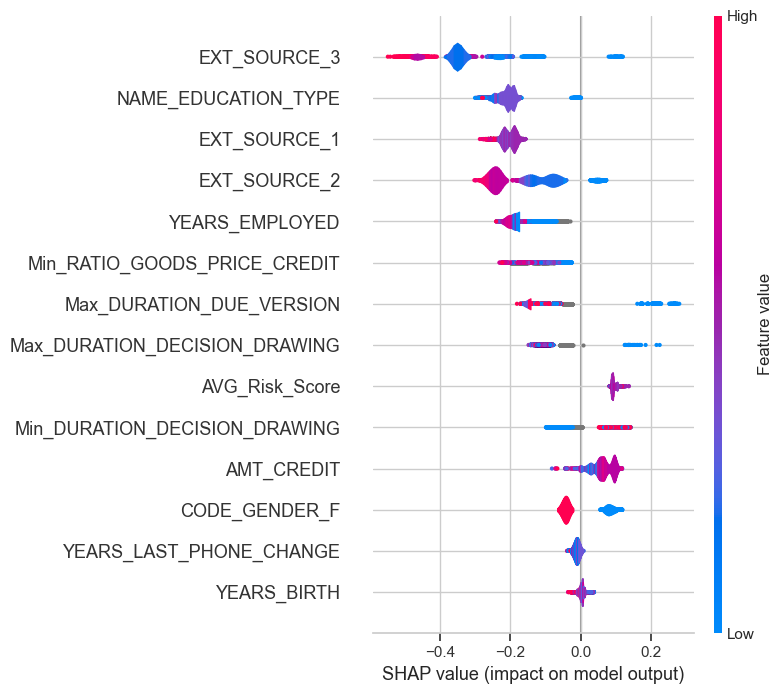

In [374]:
shap.summary_plot(shap_values, plot_type='violin', features=X_validation)

External sources drive the value lower (blue), which could mean that external sources have higher values for repaying Customers. While AVG_Risk_Score, AMT_CREDIT, Min_DURATION_DECISION_DRAWING sets model predictions higher.

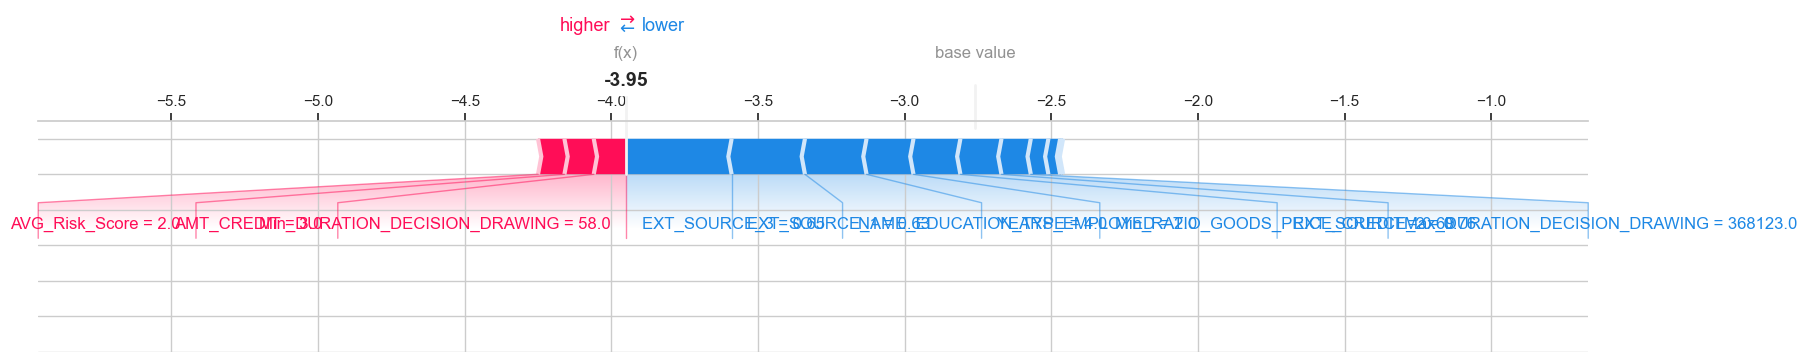

In [344]:
shap.plots.force(explainer.expected_value.round(2), shap_values[1].round(
    2), background_sample.iloc[0, :].round(2), matplotlib=True)

Loooking at concrete decissiong the model took for guessing the minority class, biggest contributor is NAME_EDUCATION_TYPE.

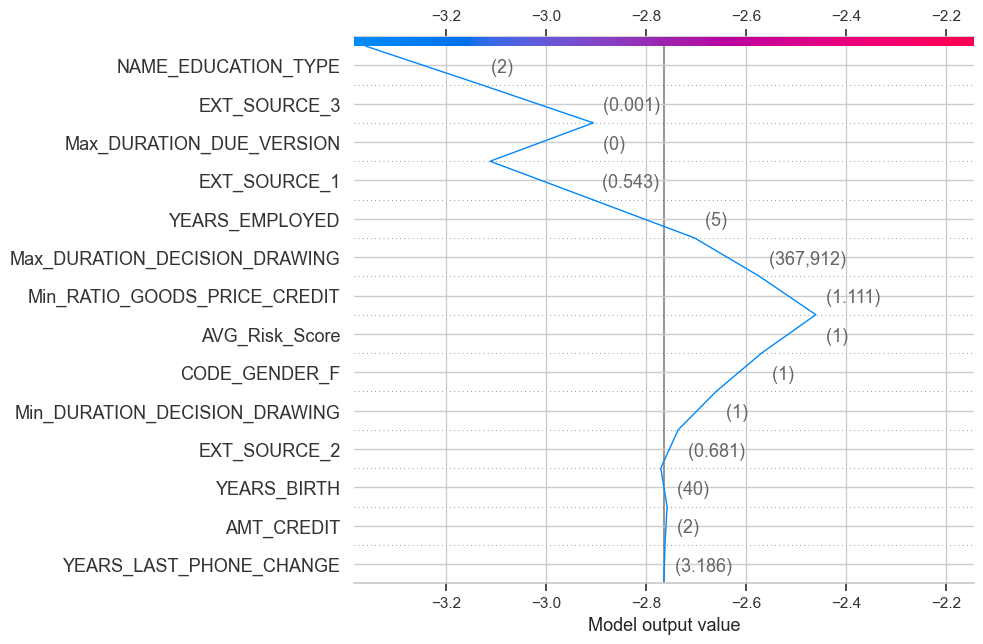

In [370]:
y_pred = lightgbm_pipeline.predict(X_validation)

class_1_indices = np.where(y_pred == 1)[0]

index = class_1_indices[1]

shap.decision_plot(explainer.expected_value, shap_values[index],
                   background_sample.iloc[index], ignore_warnings=True)

Max_DURATION_DUE_VERSION and Max_DURATION_DECISION_DRAWING seamed similar, these values were clustered and fitted for a new model, but it didn't yield good results. 

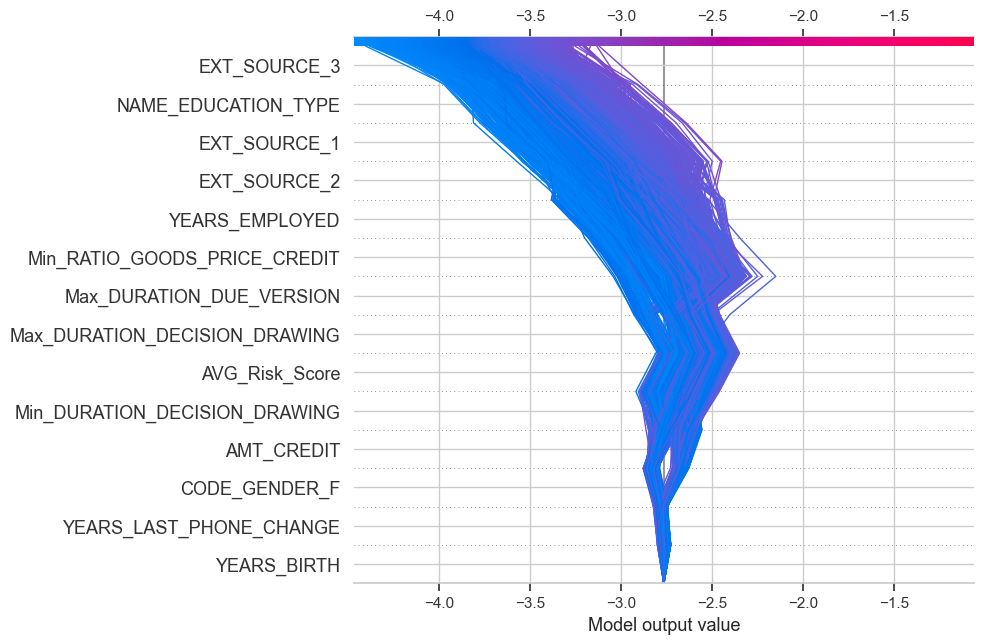

In [376]:
shap.decision_plot(explainer.expected_value, shap_values,
                   background_sample.columns, ignore_warnings=True)

Customers that take more credit than the good price requires (RATIO_GOODS_PRICE_CREDIT), are one of the main groups that the model identifies as risky.

# Conclusion
Decision Tree and LightGBM was fitted on most promising 15 features. LightGBM turned out to be the best with Precision of 0.21. SHAP value analysis showed most important features in predictions to be External Sources.